In [1]:
# Install required packages
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sqlalchemy
!pip install scipy
!pip install statsmodels
!pip install scikit-learn

# Task 1 - Exploratory Data Analysis (EDA)

## Initial Data Exploration
Connect and load the database - phishing.db. Have a general idea of the type of data in the dataset, understand the structure of the data, verify data integrity, identify what preprocessing needed, detect early patterns or problems.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import numpy as np
from scipy.stats import chi2_contingency
%matplotlib inline

engine = create_engine("sqlite:///data/phishing.db")
load_sql = "SELECT * FROM phishing_data ;"
df = pd.read_sql(load_sql, engine)

In [3]:
display(df)
display(df.info())

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,1,769.0,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,2,720.0,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,3,198.0,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,4,972.0,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,10495,NaN,43,0,0,0,0,0,0,0,0,0,Education,InfinityFree,10,0
10496,10496,20.0,207,1,1,0,0,0,0,0,0,0,Unknown,000webhost,9,0
10497,10497,NaN,129,0,0,0,0,0,2,0,0,0,eCommerce,Hostinger,2,0
10498,10498,2.0,40,0,0,0,0,0,0,0,0,0,eCommerce,000webhost,32,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10500 non-null  int64  
 1   LineOfCode         8145 non-null   float64
 2   LargestLineLength  10500 non-null  int64  
 3   NoOfURLRedirect    10500 non-null  int64  
 4   NoOfSelfRedirect   10500 non-null  int64  
 5   NoOfPopup          10500 non-null  int64  
 6   NoOfiFrame         10500 non-null  int64  
 7   NoOfImage          10500 non-null  int64  
 8   NoOfSelfRef        10500 non-null  int64  
 9   NoOfExternalRef    10500 non-null  int64  
 10  Robots             10500 non-null  int64  
 11  IsResponsive       10500 non-null  int64  
 12  Industry           10500 non-null  object 
 13  HostingProvider    10500 non-null  object 
 14  DomainAgeMonths    10500 non-null  int64  
 15  label              10500 non-null  int64  
dtypes: float64(1), int64(1

None

Insights:
- Identifier column - 'Unnamed: 0', to be drop.
- Column names in Camel case, to convert to Snake case, e.g LineOfCode -> line_of_code
- Column "LineOfCode" is in float64, to convert to int64.
- Columns "Industry" and "HostingProvider" values, to convert to lowercase.
- Columns "Robots" is binary yes/no, to convert column name to is_robots.
- NaN values in "LineOfCode" to check.
- Negative values in "NoOfImage" to check.

### Null Columns Check

In [4]:
# Nulls count for columns with percentage
null_summary = pd.DataFrame({
    'Null Count': df.isnull().sum(),
    'Null Percentage': (df.isnull().sum() / len(df)) * 100
})
display(null_summary)


,Null Count,Null Percentage
Unnamed: 0,0,0.000000
LineOfCode,2355,22.428571
LargestLineLength,0,0.000000
NoOfURLRedirect,0,0.000000
NoOfSelfRedirect,0,0.000000
NoOfPopup,0,0.000000
NoOfiFrame,0,0.000000
NoOfImage,0,0.000000
NoOfSelfRef,0,0.000000
NoOfExternalRef,0,0.000000


Insights:
- Missing value in "LineOfCode" (22%)
- Need to impute the value, due to large percentage missing, using median.
- Add a new feature "is_missing_line_of_code" (int64), 1 for missing, 0 for not, indicating originally as some philishing web site may prevent access to source? May be relevant in modeling.

### Duplicated Rows Check

In [5]:
# Drop the identifier column - 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'])

print(df.duplicated().sum())

85


Insights:
- 85 duplicated rows excluding the identifier, to drop duplicated rows.

### Statistical Information

In [6]:
# Numeric
display(df.describe())
# Categorical
display(df.describe(include=['object']))

,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,DomainAgeMonths,label
count,8145.000000,1.050000e+04,10500.000000,10500.000000,10500.000000,10500.000000,1.050000e+04,10500.00000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000
mean,1376.952363,1.119796e+04,0.136762,0.038476,0.227524,1.668381,3.252675e+02,68.54219,51.152476,0.262952,0.623619,33.170190,0.550381
std,5751.557001,9.416898e+04,0.343612,0.192352,5.700292,5.016302,3.089686e+04,316.67927,204.902781,0.440258,0.484500,32.698117,0.497479
min,2.000000,2.200000e+01,0.000000,0.000000,0.000000,0.000000,-3.500000e+01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,88.000000,1.807500e+02,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,1.000000,0.000000,0.000000,5.000000,0.000000
50%,620.000000,1.087500e+03,0.000000,0.000000,0.000000,0.000000,5.000000e+00,12.00000,10.000000,0.000000,1.000000,24.000000,1.000000
75%,1452.000000,8.047000e+03,0.000000,0.000000,0.000000,1.000000,2.500000e+01,87.00000,55.000000,1.000000,1.000000,52.000000,1.000000
max,418650.000000,4.336498e+06,1.000000,1.000000,564.000000,131.000000,3.166000e+06,26596.00000,12353.000000,1.000000,1.000000,120.000000,1.000000


,Industry,HostingProvider
count,10500,10500
unique,11,13
top,eCommerce,Unknown Provider
freq,2521,1177


Insights:
- Incorrect "NoOfImage" values, negative values to convert to 0.
- Extreme outliers in "LineOfCode", 418650.
- Extreme outliers in "LargestLineLength", 4336498.
- Extreme outliers in "NoOfpopup", 564.
- Extreme outliers in "NoOfiFrame", 131.
- Extreme outliers in "NoOfImage", 3166000.
- Extreme outliers in "NoOfSelfRef", 26596.
- Extreme outliers in "NoOfExternalRef", 12353.

Check the above extreme outliers in Univariate Analysis, can use winsorization, log1p transform and Robust scaling for the extreme outlier values above.

### Separate features into Categorical, Numerical features and Target

In [7]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
target = "label"

print(categorical_features)
print(numerical_features)
print(target)


['Industry', 'HostingProvider']
['LineOfCode', 'LargestLineLength', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfSelfRef', 'NoOfExternalRef', 'Robots', 'IsResponsive', 'DomainAgeMonths', 'label']
label


## Conclusion of Initial Data Exploration

Preprocessing To Dos:
- Identifier column - 'Unnamed: 0', to be drop.
- Column names in Camel case, to convert to Snake case, e.g LineOfCode -> line_of_code
- Column "LineOfCode" is in float64, to convert to int64.
- Columns "Industry" and "HostingProvider" values, to convert to lowercase.
- Columns "Robots" is binary yes/no, to convert column name to is_robots.
- Negative values in "NoOfImage", to clip negative value to 0.
- Missing value in "LineOfCode" (22%), to impute the value (fill with median value).
- Add a new feature "is_missing_loc" (int64), 1 for missing, 0 for not missing according to "LineOfCode".
- 85 duplicated rows excluding the identifier, to drop duplicated rows.
- Extreme outliers in "LineOfCode", 418650.
- Extreme outliers in "LargestLineLength", 4336498.
- Extreme outliers in "NoOfpopup", 564.
- Extreme outliers in "NoOfiFrame", 131.
- Extreme outliers in "NoOfImage", 3166000.
- Extreme outliers in "NoOfSelfRef", 26596.
- Extreme outliers in "NoOfExternalRef", 12353.

Consider using winsorization, log1p transform and Robust scaling for the extreme outlier values above.

## Univariate Analysis

Examine one variable at a time to understand its basic structure, patterns, distribution and potential issues before moving on to more complex multivariate analysis.

- Identify outliers
- skewness of data
- Spread of data
- Check data quality (missing values, incorrect dtype, duplicates, etc)
- Identify imbalanced feature
- Identify any feature engineering needed
- Determine the appropriate preprocessing steps such as encoding, scaling, winsorization, or log transformation.

Insights will be added below each plot.

### Analysis of features (Numerical)

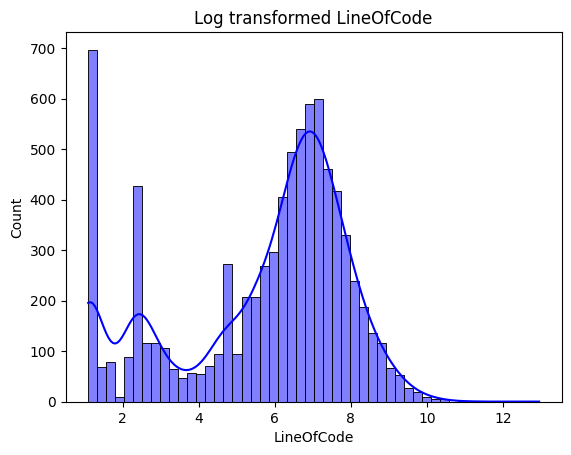

In [8]:
feature = numerical_features[0] #"LineOfCode"

# Temp log1p transformed the feature to plot, as there is extreme outlier - 418650
sns.histplot(np.log1p(df[feature]), color="blue", alpha=0.5, bins=50, kde=True)
plt.title(f"Log transformed {feature}")
plt.show()

Insights:
- Log transformed LineOfCode distribution is right-skewed.
- The distribution appears multi-modal, suggesting that the dataset contains distinct classes of web pages.
- Consider Winsorize, Log1p and Robust scaling this feature, due to the huge values of the outliers.

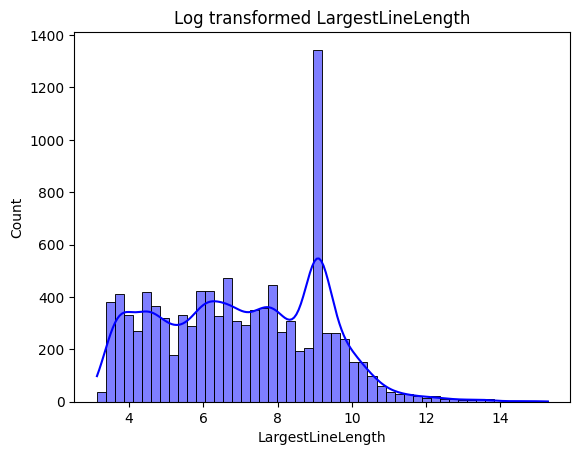

In [9]:
feature = numerical_features[1] #"LargestLineLength"

# Temp log1p transformed the feature to plot, as there is extreme outlier - 4336498 
sns.histplot(np.log1p(df[feature]), color="blue", alpha=0.5, bins=50, kde=True)

plt.title(f"Log transformed {feature}")
plt.show()

Insights:
- some extreme huge outliers at log size 11-15.
- Most common "LargestLineLength" is at log size 9.
- Consider Winsorize, Log1p and Robust scaling this feature, due to the huge values of the outliers.

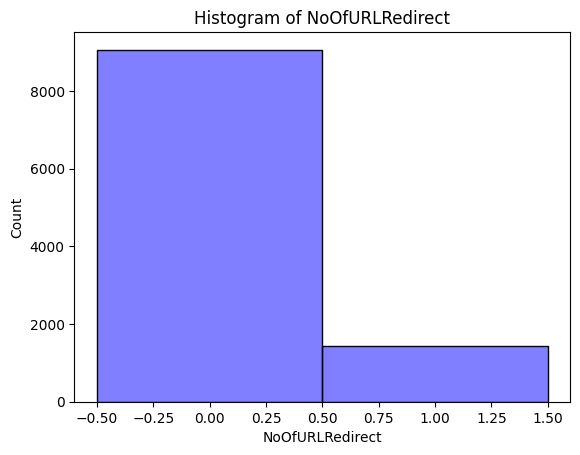

In [10]:
feature = numerical_features[2] #"NoOfURLRedirect"
sns.histplot(data=df, x=feature, discrete=True, bins=3, color="blue", alpha=0.5, kde=False)
plt.title(f"Histogram of {feature}")
plt.show()

Insights:
- Seems like binary, but should not affect modeling.
- Most are 0 (no URL redirect), only small numbers redirect URL 1 time.
- No transformation is needed.

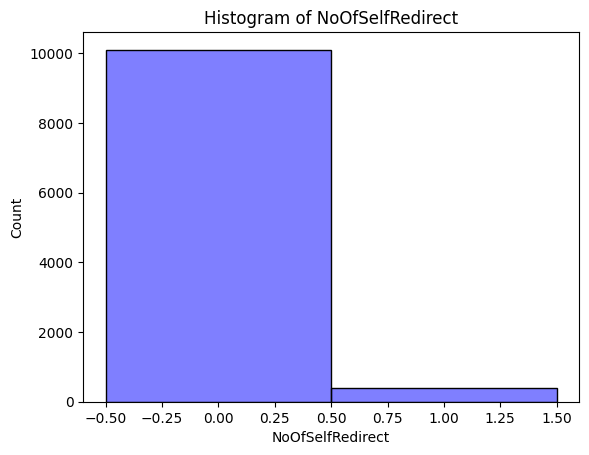

In [11]:
feature = numerical_features[3] #"NoOfSelfRedirect"
sns.histplot(data=df, x=feature, discrete=True, bins=3, color="blue", alpha=0.5, kde=False)
plt.title(f"Histogram of {feature}")
plt.show()

Insights:
- Seems like binary, but should not affect modeling.
- Most are 0 (no self redirect), only small numbers self redirect 1 time.
- Those small numbers that self redirect may indicate phishing web site.
- No transformation is needed.

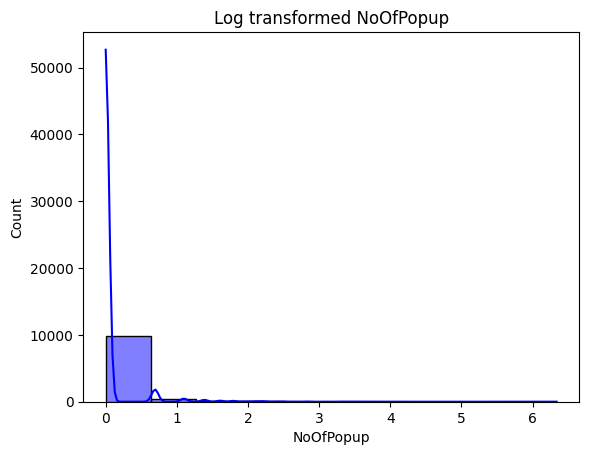

Number of rows where NoOfPopup > 0: 606
Number of rows where NoOfPopup == 0: 9894


In [12]:
feature = numerical_features[4] #"NoOfPopup"

# Log transformed the feature to plot, as there is extreme outlier - 564
sns.histplot(np.log1p(df[feature]), color="blue", alpha=0.5, bins=10, kde=True)
plt.title(f"Log transformed {feature}")
plt.show()

count_non_zero = (df[feature] > 0).sum()
count_zero = (df[feature] == 0).sum()
print(f"Number of rows where {feature} > 0:", count_non_zero)
print(f"Number of rows where {feature} == 0:", count_zero)

Insights:
- Highly right skewed, long tailed.
- Most site does not have pop up (log size 0).
- Some extreme number of pop up (log size 5-6).
- Consider adding a binary feature "has_popup", those with pop up is 1, no pop up is 0.
- Consider Winsorize, Log1p and Robust scaling this feature, due to the huge values of the outliers.

Due to extreme outliers and heavy skew, preprocessing with winsorization, log1p and robust scaling is recommended before training ML models.

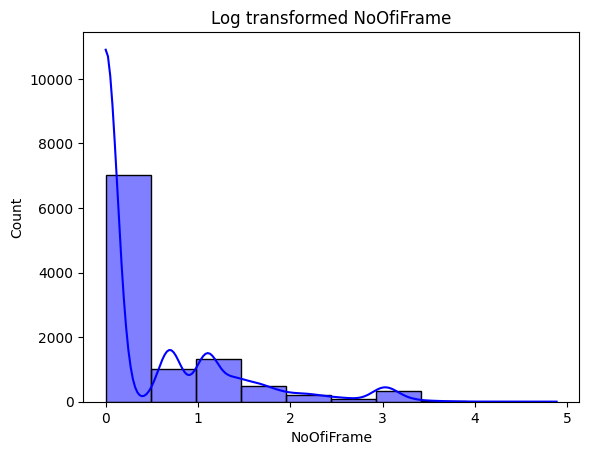

Number of rows where NoOfiFrame > 0: 3483
Number of rows where NoOfiFrame == 0: 7017


In [13]:
feature = numerical_features[5] #"NoOfiFrame"

# Log transformed the feature to plot, as there is extreme outlier - 131
sns.histplot(np.log1p(df[feature]), color="blue", alpha=0.5, bins=10, kde=True)
plt.title(f"Log transformed {feature}")
plt.show()

count_non_zero = (df[feature] > 0).sum()
count_zero = (df[feature] == 0).sum()
print(f"Number of rows where {feature} > 0:", count_non_zero)
print(f"Number of rows where {feature} == 0:", count_zero)

Insights:
- Highly right skewed, long tailed.
- Most do not use iFrame in site.
- Some use extreme numbers of iFrame (log size 4-5).
- Legitmate sites usually do not use or use small numbers to embed image or video.
- Consider adding a binary feature "has_iframe", those with iframe is 1, no iframe is 0.
- Consider Winsorize, Log1p and Robust scaling this feature, due to the huge values of the outliers.

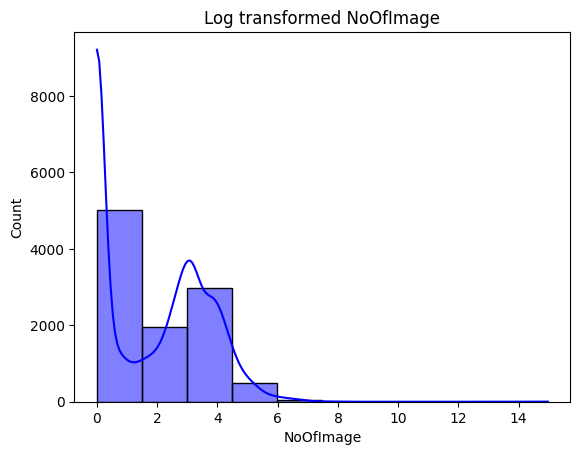

Number of rows where NoOfImage > 0: 6274
Number of rows where NoOfImage == 0: 4226


In [14]:
feature = numerical_features[6] #"NoOfImage"

# clip to 0 for negative number of image
df[feature] = df[feature].clip(lower=0)

# Log transformed the feature to plot, as there is extreme outlier - 3166000
sns.histplot(np.log1p(df[feature]), color="blue", alpha=0.5, bins=10, kde=True)
plt.title(f"Log transformed {feature}")
plt.show()

count_non_zero = (df[feature] > 0).sum()
count_zero = (df[feature] == 0).sum()
print(f"Number of rows where {feature} > 0:", count_non_zero)
print(f"Number of rows where {feature} == 0:", count_zero)

Insights:
- Clip negative value to 0.
- Highly right skewed, long tailed.
- Most sites have small number of images(log size 0-2).
- Some sites have a large number of images (extreme tail)
- Consider adding a binary feature "has_image", those with image is 1, no image is 0.
- Consider Winsorize, Log1p and Robust scaling this feature, due to the huge values of the outliers.

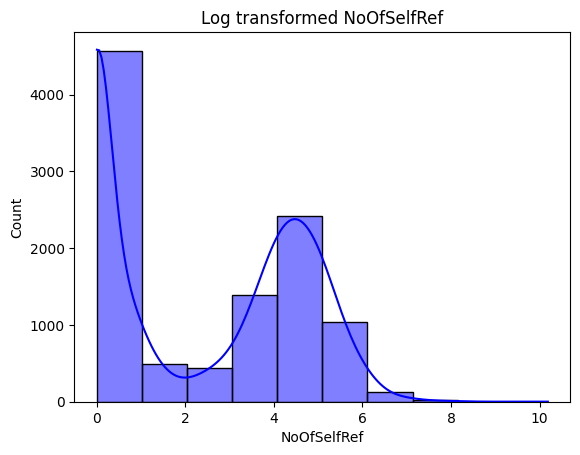

Number of rows where NoOfSelfRef > 0: 6690
Number of rows where NoOfSelfRef == 0: 3810


In [15]:
feature = numerical_features[7] #"NoOfSelfRef"

# Log transformed the feature to plot, as there is extreme outlier - 26596
sns.histplot(np.log1p(df[feature]), color="blue", alpha=0.5, bins=10, kde=True)
plt.title(f"Log transformed {feature}")
plt.show()

count_non_zero = (df[feature] > 0).sum()
count_zero = (df[feature] == 0).sum()
print(f"Number of rows where {feature} > 0:", count_non_zero)
print(f"Number of rows where {feature} == 0:", count_zero)

Insights:
- Right skewed.
- Most sites have small number of self reference (log size 0-1).
- Consider Winsorize, Log1p and Robust scaling this feature, due to the huge values of the outliers.

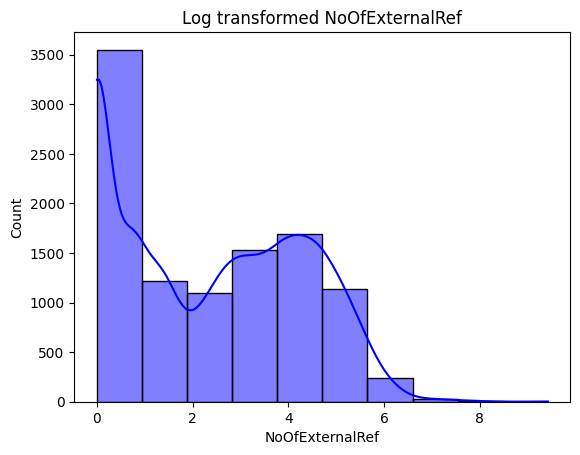

Number of rows where NoOfExternalRef > 0: 7978
Number of rows where NoOfExternalRef == 0: 2522


In [16]:
feature = numerical_features[8] #"NoOfExternalRef"

# Log transformed the feature to plot, as there is extreme outlier - 12353
sns.histplot(np.log1p(df[feature]), color="blue", alpha=0.5, bins=10, kde=True)
plt.title(f"Log transformed {feature}")
plt.show()

count_non_zero = (df[feature] > 0).sum()
count_zero = (df[feature] == 0).sum()
print(f"Number of rows where {feature} > 0:", count_non_zero)
print(f"Number of rows where {feature} == 0:", count_zero)

Insights:
- Right skewed.
- Most sites have small number of external reference (log size 0-1).
- Consider Winsorize, Log1p and Robust scaling this feature, due to the huge values of the outliers.

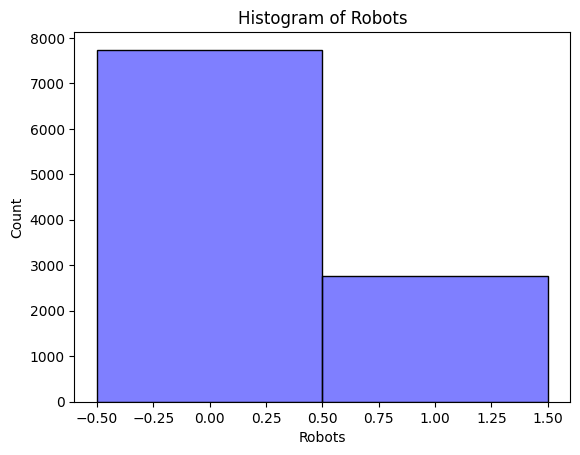

In [17]:
feature = numerical_features[9] #"Robots"

sns.histplot(data=df, x=feature, discrete=True, bins=3, color="blue", alpha=0.5, kde=False)
plt.title(f"Histogram of {feature}")
plt.show()

Insights:
- Binary feature.
- Most sites does not have robots.txt (0).
- Consider renaming the column name to "is_robots" to better reflect the feature does.
- No transformation is needed.

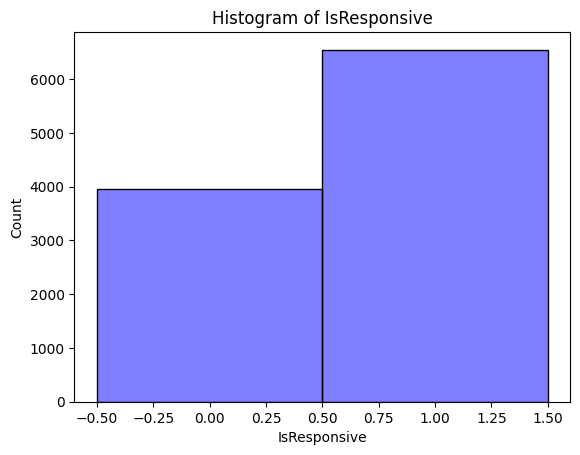

In [18]:
feature = numerical_features[10] #"IsResponsive"

sns.histplot(data=df, x=feature, discrete=True, bins=3, color="blue", alpha=0.5, kde=False)
plt.title(f"Histogram of {feature}")
plt.show()

Insights:
- Binary feature.
- Most sites are responsive (1).
- No transformation is needed.

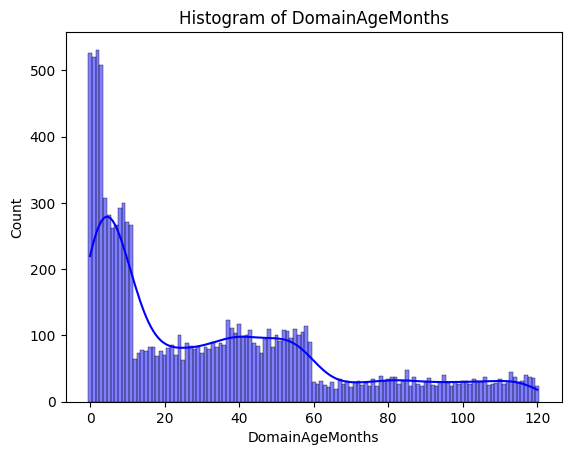

In [19]:
feature = numerical_features[11] #"DomainAgeMonths"

sns.histplot(data=df, x=feature, discrete=True, bins=10, color="blue", alpha=0.5, kde=True)
plt.title(f"Histogram of {feature}")
plt.show()

Insights:
- Distribution is multi-modal.
- Largest count for young domain age (0-6 months).
- Most phishing site will be in this group, there are alive only for a few months as there will be close by hosting company or government agency as phishing is detected.
- Other long age domain usually belong to legitmate companies.
- No transformation is needed.

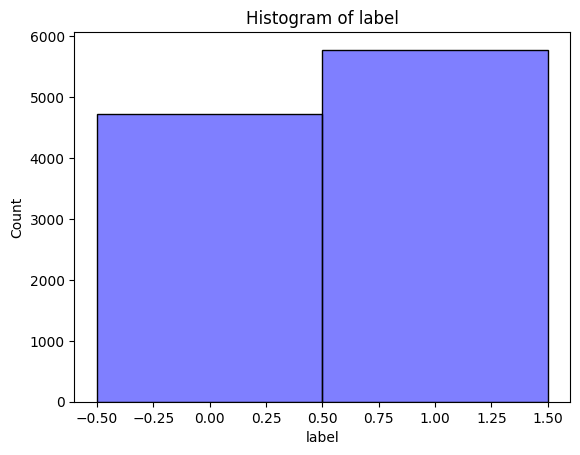

1: 0.5503809523809524
0: 0.4496190476190476


In [20]:
feature = numerical_features[12] #"label"

sns.histplot(data=df, x=feature, discrete=True, bins=3, color="blue", alpha=0.5, kde=False)
plt.title(f"Histogram of {feature}")
plt.show()

print(f"1: {df['label'].mean()}")
print(f"0: {1 - df['label'].mean()}")

Insights:
- This the target variable.
- Slightly imbalanced dataset.
- No transformation is needed.

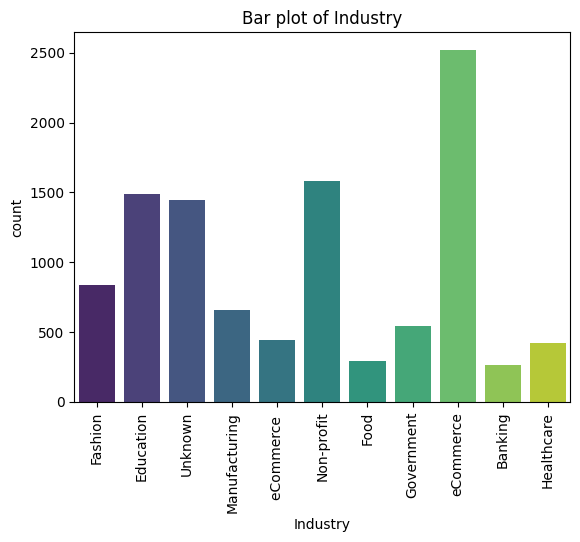

In [21]:
feature = categorical_features[0] #Industry

sns.countplot(x=feature, data=df, hue=feature, palette='viridis', legend=False)
plt.title(f"Bar plot of {feature}")
plt.xticks(rotation=90)
plt.show()

Insights:
- ecommerce forms the biggest group.
- Phishing sites often imitate online shops.
- There are two "eCommerce" in the plot, may be one of them got an extra space infront or behind, to clean it.
- Encode with OneHotEncoder so that most ML models can interpret this categorical values properly.

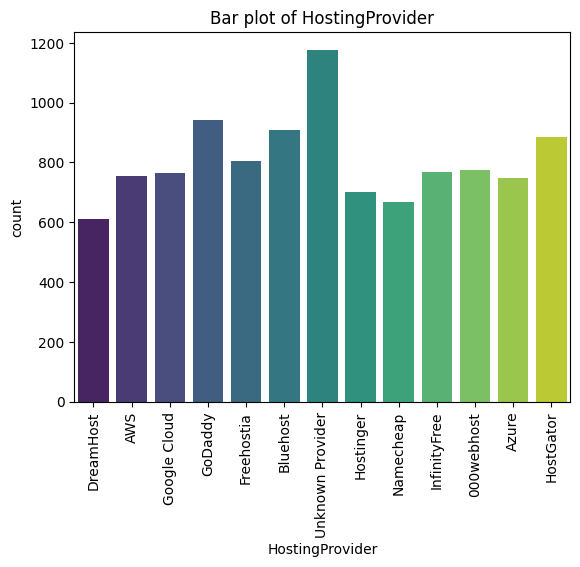

In [22]:
feature = categorical_features[1] #Hosting Provider

sns.countplot(x=feature, data=df, hue=feature, palette='viridis', legend=False)
plt.title(f"Bar plot of {feature}")
plt.xticks(rotation=90)
plt.show()

Insights:
- Biggest group are hosting on Unknown Provider.
- May be good predictor, phishing site often are hosted on free or cheap hosting provider.
- Encode with OneHotEncoder so that most ML models can interpret this categorical values properly.

## Conclusion of Univariate analysis

Preprocessing To Dos:
- Winsorize, Log1p and Robust scaling for these features - 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfSelfRef', 'NoOfExternalRef'.
- OneHotEncoding for categorical features - "Industry", "HostingProvider".
- Strip whitespace from "Industry", to resolve two ecommerce industry currently.
- Renaming the column name of "Robots" to "is_robots" to better reflect the feature.
- Add binary feature "has_popup", sites NoOfPopup > 0 is 1, else 0.
- Add binary feature "has_iframe", sites NoOfiFrame > 0 is 1, else 0.
- Add binary feature "has_image", sites NoOfImage > 0 is 1, else 0.

## Multi-Variate Analysis

Multi-Variate analysis is used to explore relationships between the feature variables and the target variable, understand how they interact, compare groups, detect patterns, detect potential multicollinearity issues and improved understanding before modeling.

### Numerical vs. Target (Categorical)

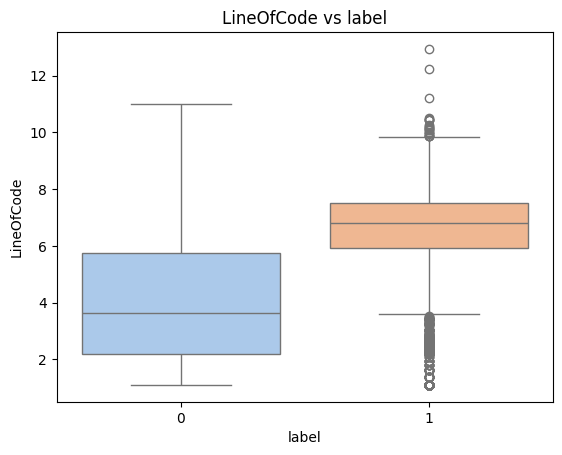

In [23]:
feature = numerical_features[0] #LineOfCode

# Log transform the feature due to extreme outliers, huge value.
sns.boxplot(x='label', y=np.log1p(df[feature]), data=df, hue=target, palette="pastel", legend=False)

plt.xticks(rotation=0)
plt.title(f"{feature} vs {target}")
plt.show()


Insights:
- The "LineOfCode" median tend to be lower if is a phishing site.
- The "LineOfCode" for non phishing site varies greatly, this could be due to the many different type of web sites such as small personal site to medium corporate site to large ecommerce site.
- May not be strong predictor due to large overlap between them,the feature cannot cleanly separate the classes.

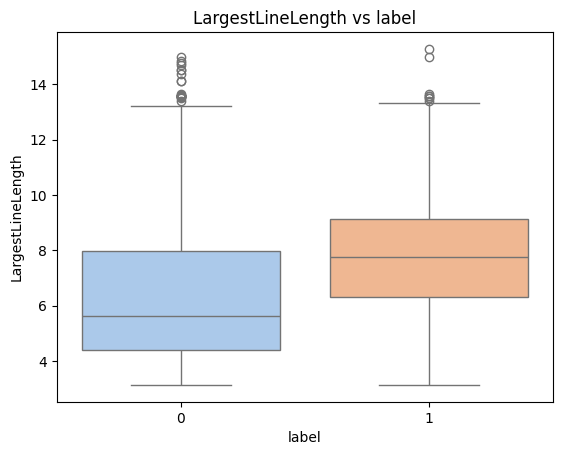

In [24]:
feature = numerical_features[1] #LargestLineLength

# Log transform the feature due to extreme outliers, huge value.
sns.boxplot(x='label', y=np.log1p(df[feature]), data=df, hue=target, palette="pastel", legend=False)

plt.xticks(rotation=0)
plt.title(f"{feature} vs {target}")
plt.show()


Insights:
- Legitimate web site tend to have higher median value for "LargestLineLength", this could be due to more minified Javascript sources, CSS sources or external UI libraries such as Bootstrap sources.
- Phishing web site have lower median, this could be due to phishing site only using minimal static HTML page that just does the job of collecting login information, redirecting to other site, and minimal JS required.
- May not be strong predictor due to overlap between them,the feature cannot cleanly separate the classes (May perform better when combine with other features).

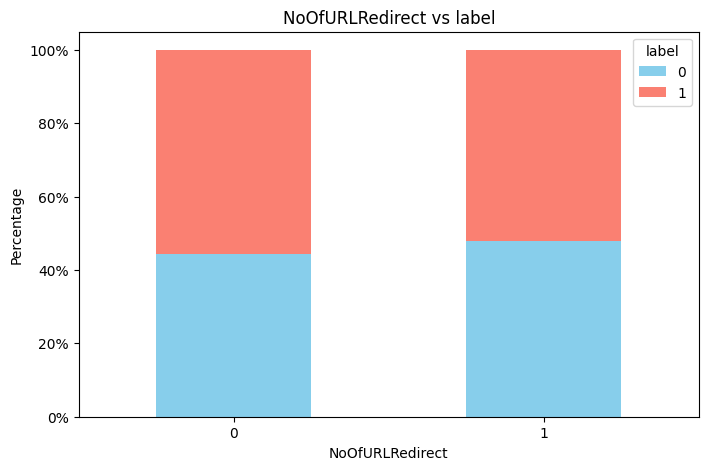

NoOfURLRedirect
0    0.555163
1    0.520195
Name: label, dtype: float64


In [25]:
feature = numerical_features[2] # NoOfURLRedirect
fig, ax = plt.subplots(figsize=(8, 5))
cross = pd.crosstab(df[feature], df[target], normalize="index")
cross.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=ax, legend=True)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
ax.set_title(f"{feature} vs {target}")
ax.set_xlabel(f"{feature}")
ax.set_ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()

print(df.groupby(feature)[target].mean())

Insights:
- Both almost same percentage for legitimate, whether "NoOfURLRedirect" is 0 or 1.
- Because both classes appear in almost equal proportions for both values of NoOfURLRedirect, this feature provides almost no predictive power.

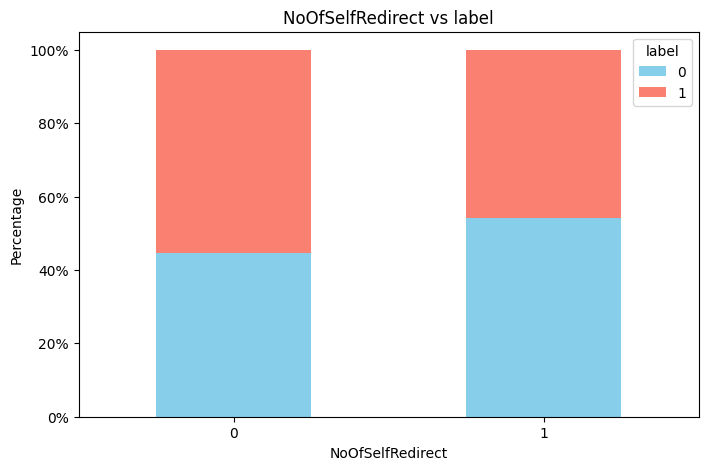

In [26]:
feature = numerical_features[3] # NoOfSelfRedirect
fig, ax = plt.subplots(figsize=(8, 5))
cross = pd.crosstab(df[feature], df[target], normalize="index")
cross.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=ax, legend=True)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
ax.set_title(f"{feature} vs {target}")
ax.set_xlabel(f"{feature}")
ax.set_ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()


Insights:
- When NoOfSelfRedirect = 0, the proportion of legitimate sites (label = 1) is slightly higher compared to phishing sites.
This suggests that most legitimate sites do not perform self-redirects.
- When NoOfSelfRedirect = 1, the proportion of phishing sites (label = 0) increases by roughly 10%, meaning phishing sites are slightly more likely to perform a self-redirect.
- Not a strong standalone predictor.
The class separation is weak, and this feature provides very limited discriminatory power on its own.

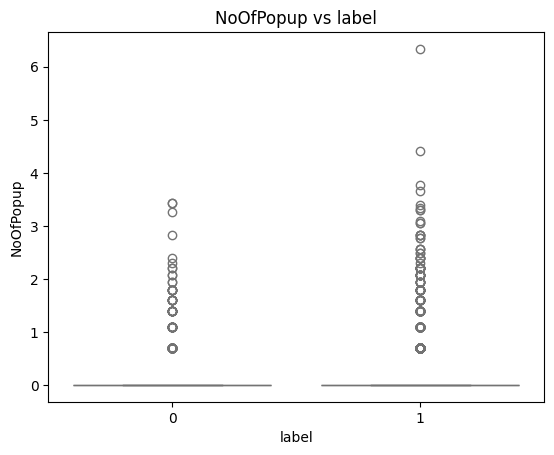

In [27]:
feature = numerical_features[4] #NoOfPopup

# Log transform the feature due to extreme outliers, huge value.
sns.boxplot(x='label', y=np.log1p(df[feature]), data=df, hue=target, palette="pastel", legend=False)

plt.xticks(rotation=0)
plt.title(f"{feature} vs {target}")
plt.show()

Insights:
- Both have similar median.
- Both phishing (label = 0) and legitimate sites (label = 1) have almost identical distributions of NoOfPopup.
- The median for both groups is 0, meaning most websites, regardless of type, do not use popups.
- Not a good predictor, no meaningful separation between the classes.

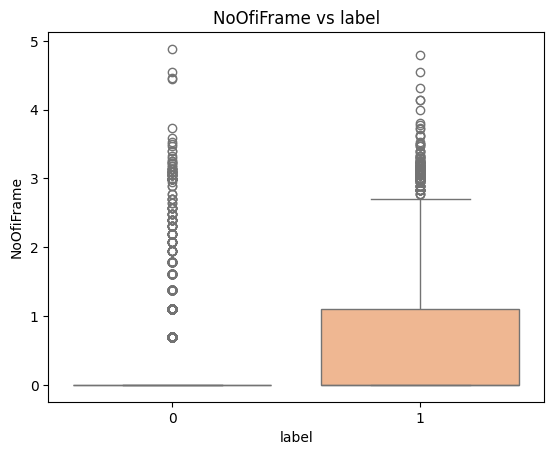

In [28]:
feature = numerical_features[5] #LargestLineLength

# Log transform the feature due to extreme outliers, huge value.
sns.boxplot(x='label', y=np.log1p(df[feature]), data=df, hue=target, palette="pastel", legend=False)

plt.xticks(rotation=0)
plt.title(f"{feature} vs {target}")
plt.show()

Insights:
- Legitimate websites (label = 1) tend to use more iFrames, such as embedded videos and embedded ads.
- Phishing sites (label = 0) mostly have 0 iFrames, such as simple static templates.
- May be moderate predictor.

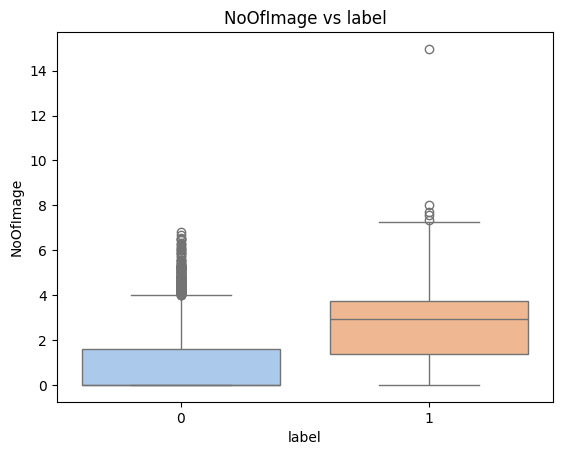

In [29]:
feature = numerical_features[6] #NoOfImage

# Log transform the feature due to extreme outliers, huge value.
sns.boxplot(x='label', y=np.log1p(df[feature]), data=df, hue=target, palette="pastel", legend=False)

plt.xticks(rotation=0)
plt.title(f"{feature} vs {target}")
plt.show()

Insights:
- Legitimate websites (label = 1) have a higher median number of images.
- Phishing websites (label = 0) have a much lower median number of images.
- Maybe good predictor.

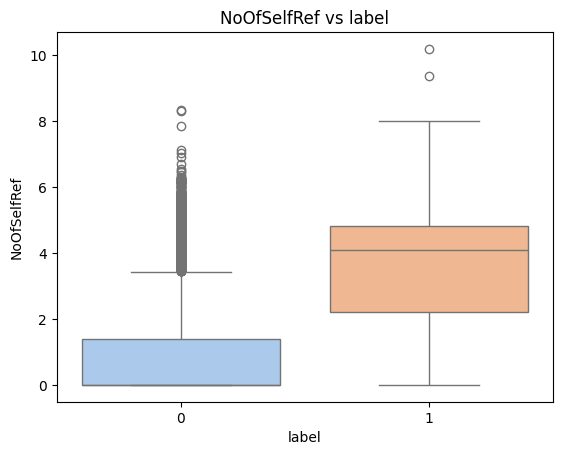

In [30]:
feature = numerical_features[7] #NoOfSelfRef

# Log transform the feature due to extreme outliers, huge value.
sns.boxplot(x='label', y=np.log1p(df[feature]), data=df, hue=target, palette="pastel", legend=False)

plt.xticks(rotation=0)
plt.title(f"{feature} vs {target}")
plt.show()

Insights:
- Phishing websites (label = 0) have a noticeably lower median NoOfSelfRef.
- Legitimate websites (label = 1) have a much higher median NoOfSelfRef.
- May be good predictor.

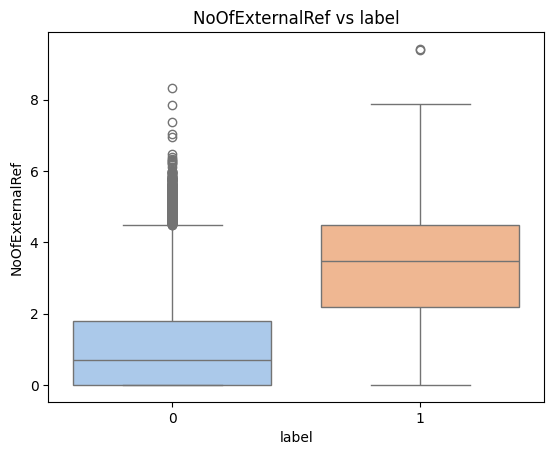

In [31]:
feature = numerical_features[8] #NoOfExternalRef

# Log transform the feature due to extreme outliers, huge value.
sns.boxplot(x='label', y=np.log1p(df[feature]), data=df, hue=target, palette="pastel", legend=False)

plt.xticks(rotation=0)
plt.title(f"{feature} vs {target}")
plt.show()

Insights:
- Phishing websites (label = 0) have a lower median NoOfExternalRef.
- Legitimate websites (label = 1) have a much higher median NoOfExternalRef.
- May be good predictor.

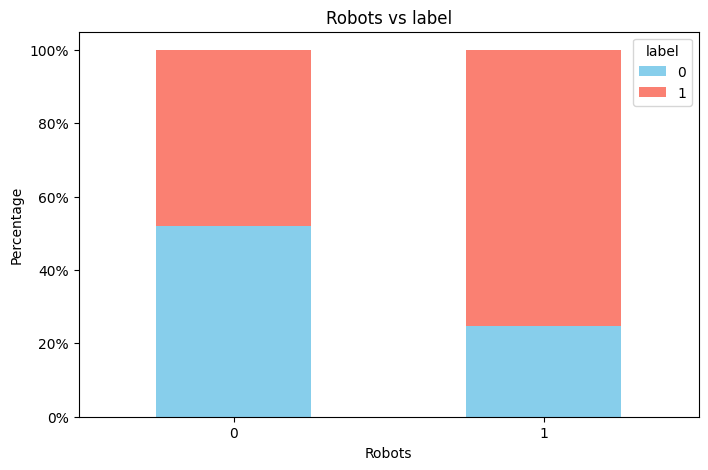

In [32]:
feature = numerical_features[9] # Robots
fig, ax = plt.subplots(figsize=(8, 5))
cross = pd.crosstab(df[feature], df[target], normalize="index")
cross.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=ax, legend=True)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
ax.set_title(f"{feature} vs {target}")
ax.set_xlabel(f"{feature}")
ax.set_ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()

Insights:
- When Robots = 1 (robots.txt file exists), the proportion of legitimate websites (label = 1) is noticeably higher.
- When Robots = 0, the proportion of phishing websites (label = 0) increases significantly.
- May be a good predictor.

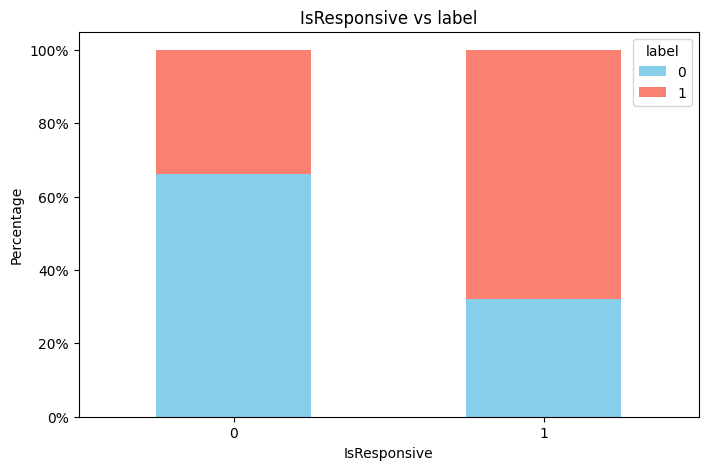

In [33]:
feature = numerical_features[10] # IsResponsive
fig, ax = plt.subplots(figsize=(8, 5))
cross = pd.crosstab(df[feature], df[target], normalize="index")
cross.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=ax, legend=True)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
ax.set_title(f"{feature} vs {target}")
ax.set_xlabel(f"{feature}")
ax.set_ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()

Insights:
- When IsResponsive = 1, the proportion of legitimate websites (label = 1) is significantly higher.
- When IsResponsive = 0, the proportion of phishing websites (label = 0) increases noticeably.
- May be good predictor.

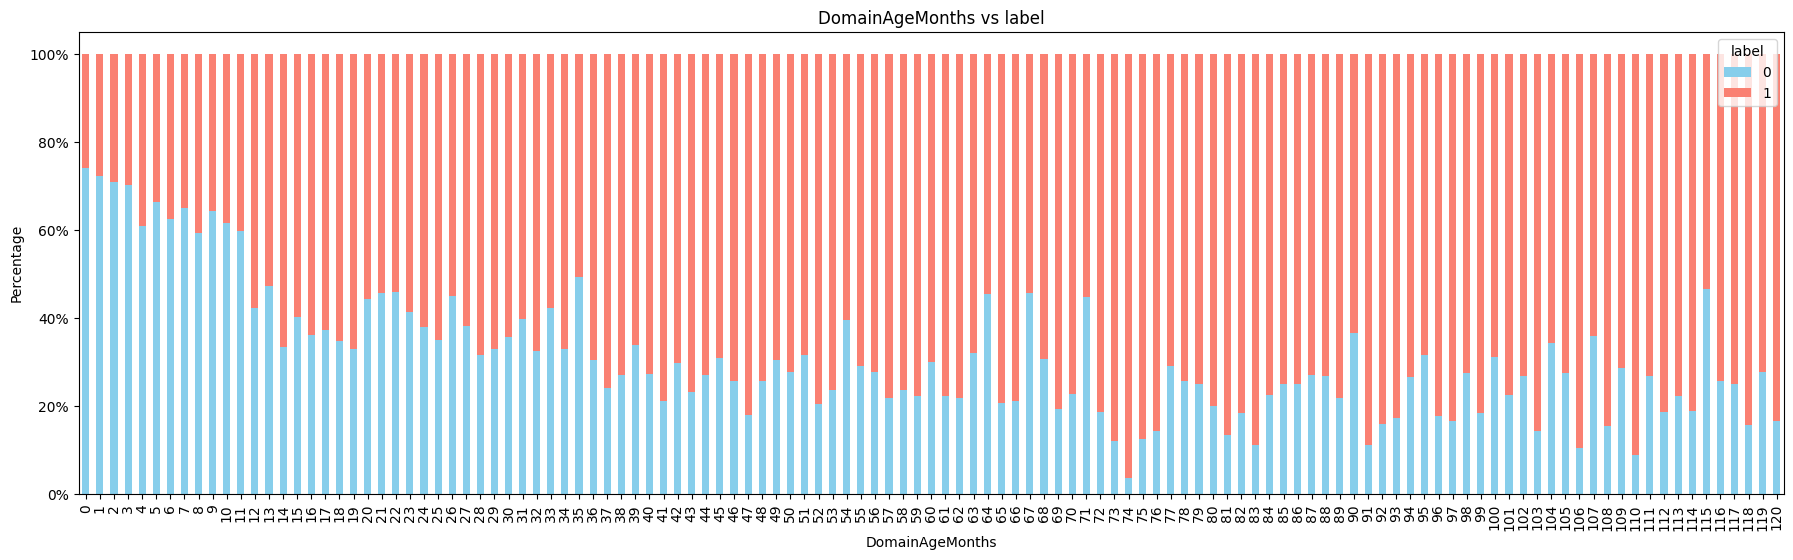

In [34]:
feature = numerical_features[11] # DomainAgeMonths
fig, ax = plt.subplots(figsize=(22, 6))
cross = pd.crosstab(df[feature], df[target], normalize="index")
cross.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=ax, legend=True)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
ax.set_title(f"{feature} vs {target}")
ax.set_xlabel(f"{feature}")
ax.set_ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

Insights:
- First to 12 months of "DomainAgeMonths" has the highest phishing web sites.
- Legitimate sites tend to increase with age.
- Will be good predictor.

### Categorical vs Target (Categorical)

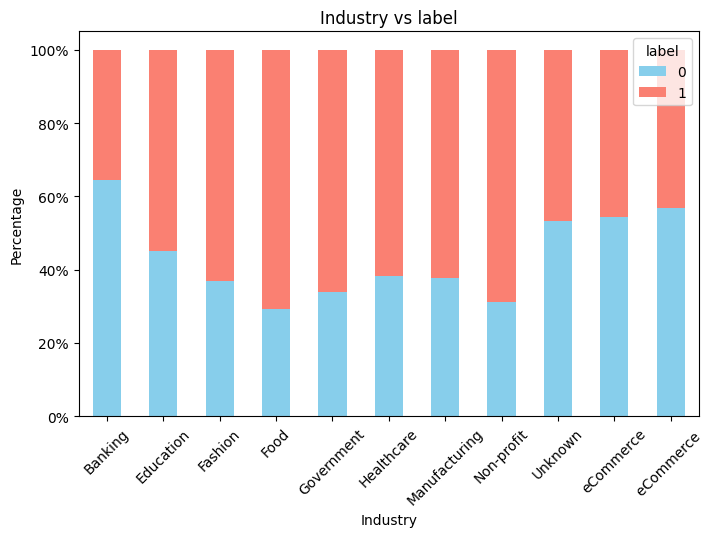

p value: 0.0000


In [35]:
feature = categorical_features[0]  # Industry
fig, ax = plt.subplots(figsize=(8, 5))
cross = pd.crosstab(df[feature], df[target], normalize="index")
cross.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=ax, legend=True)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
ax.set_title(f"{feature} vs {target}")
ax.set_xlabel(f"{feature}")
ax.set_ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

contingency = pd.crosstab(df[feature], df[target])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"p value: {p:.4f}")

Insights:
- Banking, eCommerce, and Unknown industries have the highest proportion of phishing websites (label = 0)
- Industries such as Education, Healthcare, Government, Fashion, Food, and Manufacturing show a higher proportion of legitimate websites (label = 1).
- Chi-Square independence test p < 0.05, Industry and label are dependent.
- May be good predictor.

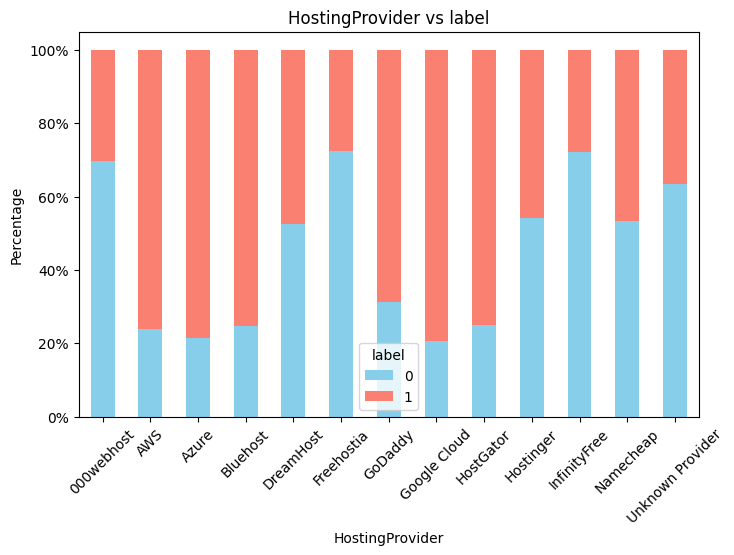

p value: 0.0000


In [36]:
feature = categorical_features[1]  # HostingProvider
fig, ax = plt.subplots(figsize=(8, 5))
cross = pd.crosstab(df[feature], df[target], normalize="index")
cross.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], ax=ax, legend=True)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
ax.set_title(f"{feature} vs {target}")
ax.set_xlabel(f"{feature}")
ax.set_ylabel("Percentage")
plt.xticks(rotation=45)
plt.show()

contingency = pd.crosstab(df[feature], df[target])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"p value: {p:.4f}")

Insights:
- 000webhost, Freehostia, InfinityFree, and Unknown Provider show the highest proportions of phishing websites (label = 0).
- Premium or reputable hosting providers (AWS, Azure, Google Cloud, GoDaddy, HostGator, Bluehost) show a much lower proportion of phishing sites and a higher portion of legitimate websites (label = 1).
- Chi-Square independence test p < 0.05, HostingProvider and label are dependent.
- May be good predictor.

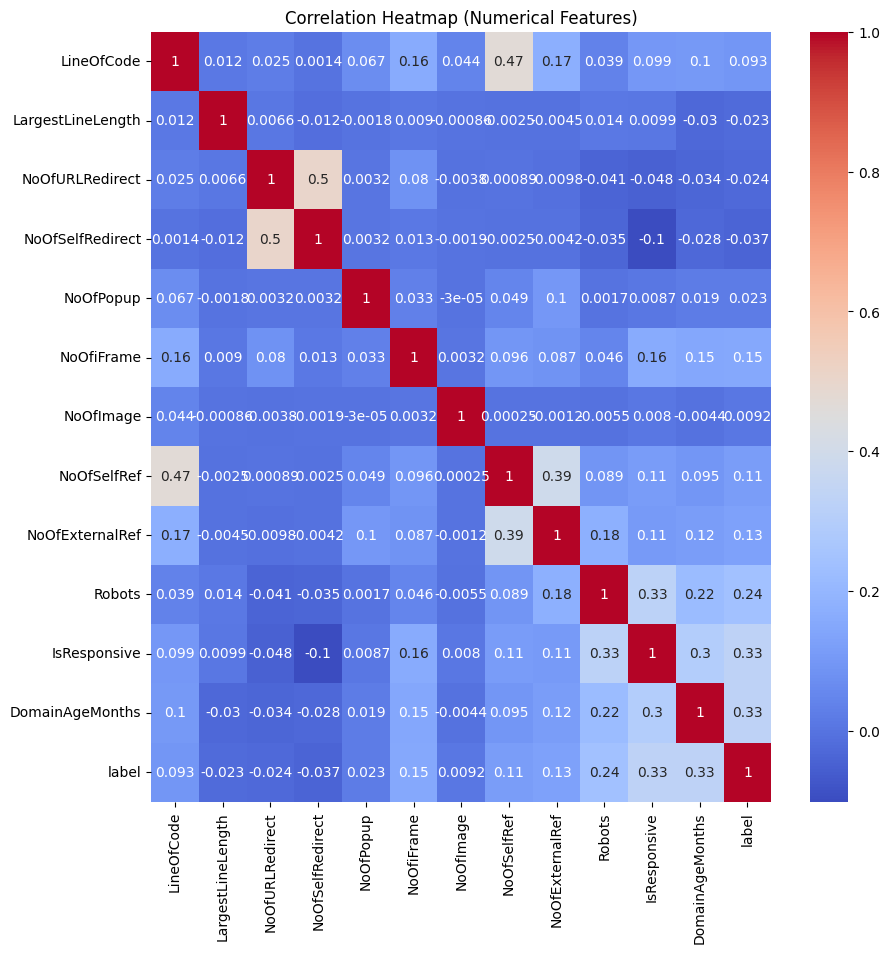

In [37]:
corr_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

Linear correlations.

Strong Predictors:
- DomainAgeMonths (+0.33)
- IsResponsive (+0.33)
- Robots (+0.24)
  
Moderate Predictors:
- NoOfIframe (+0.15)
- NoOfExternalRef (+0.13)
- NoOfSelfRef (+0.11)

Weak Predictors:
- LineOfCode (0.093)
- NoOfPopup (+0.023)
- NoOfImage (+0.0092)
- LargestLineLength (-0.023)
- NoOfURLRedirect (-0.024)
- NoOfSelfRedirect (-0.037)


## Conclusion Multivariate Analysis

Based on the correlation analysis, bi-variate plots, and categorical–target comparisons:

Strong Predictors:
- Industry
- HostingProvider
- DomainAgeMonths
- IsResponsive
- Robots
- NoOfImage (May be strong non linear feature as in bi-variate plot)

These features show strong statistical association with the phishing label and clear separation in the distributions. They are likely to be major contributors in most models.
  
Moderate Predictors:
- NoOfIframe
- NoOfExternalRef (May be strong non linear feature as in bi-variate plot)
- NoOfSelfRef (May be strong non linear feature as in bi-variate plot)

These features show noticeable differences across classes and may provide additional predictive value, especially when combined with the strong predictors.

Weak Predictors:
- LineOfCode
- NoOfPopup
- LargestLineLength
- NoOfURLRedirect
- NoOfSelfRedirect

These variables exhibit weak standalone signal and low correlation with the target. However, they may still contribute through nonlinear interactions

We can start by training the model using strong + moderate features.
Weak features can be tested during feature-selection or model comparison to check if they improve performance.
The pipeline allows dropping any feature iteratively to find the optimal combination.
  